In [4]:
import pandas as pd

df = pd.read_csv("activities_cleaned.csv")
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print(data)

Shape: (155, 28)
Columns: ['Activity ID', 'Activity Type', 'Begin Timestamp', 'End Timestamp', 'Max. Elevation (Raw)', 'Min. Elevation (Raw)', 'Elevation Gain (Raw)', 'Elevation Loss (Raw)', 'Average Heart Rate (bpm)', 'Max. Heart Rate (bpm).1', 'Average Moving Speed', 'Average Speed', 'Max. Speed', 'Distance (Raw)', 'Duration (h:m:s)', 'Moving Duration (h:m:s)', 'Calories', 'Device', 'Begin Latitude (Decimal Degrees Raw)', 'Begin Longitude (Decimal Degrees Raw)', 'End Latitude (Decimal Degrees Raw)', 'End Longitude (Decimal Degrees Raw)', 'Temperature (Raw)', 'Wind Speed (Raw)', 'Wind Direction', 'Humidity (Raw)', 'Condition', 'Rainfall']
     Activity ID Activity Type   Begin Timestamp     End Timestamp  \
0     2284658991       Running   4/11/2017 12:07   4/11/2017 13:06   
1     2284658936       Running    3/11/2017 9:47   3/11/2017 10:35   
2     2228102647       Running  25/10/2017 16:31  25/10/2017 17:11   
3     2104984694       Running  13/10/2017 11:53  13/10/2017 12:41   
4 

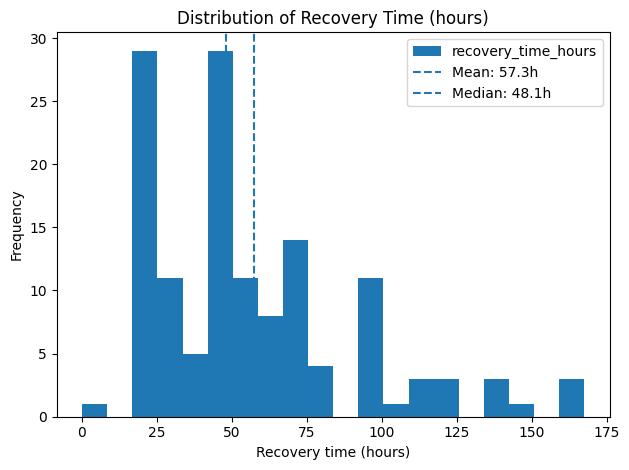

<Figure size 640x480 with 0 Axes>

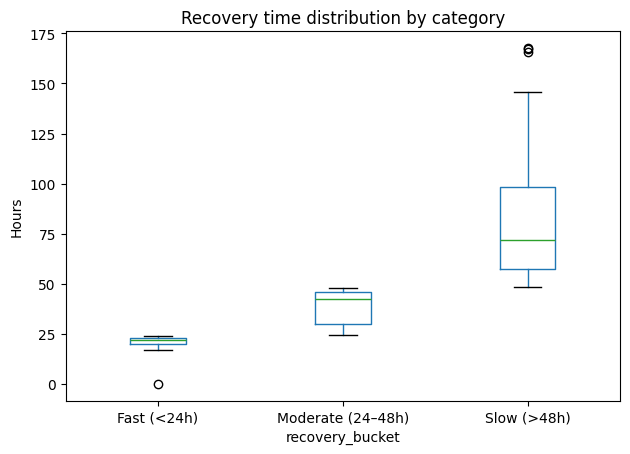

In [11]:
# --- STEP 2 VISUALS: Recovery time distribution & buckets ---

import matplotlib.pyplot as plt

# 2A) Histogram of recovery_time_hours
plt.figure()
df_model["recovery_time_hours"].plot(kind="hist", bins=20)
plt.axvline(df_model["recovery_time_hours"].mean(), linestyle="--", label=f"Mean: {df_model['recovery_time_hours'].mean():.1f}h")
plt.axvline(df_model["recovery_time_hours"].median(), linestyle="--", label=f"Median: {df_model['recovery_time_hours'].median():.1f}h")
plt.title("Distribution of Recovery Time (hours)")
plt.xlabel("Recovery time (hours)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig("plot_recovery_time_hist.png", dpi=160)
plt.show()

# 2B) Boxplot by recovery buckets
plt.figure()
df_model.boxplot(column="recovery_time_hours", by="recovery_bucket", grid=False)
plt.title("Recovery time distribution by category")
plt.suptitle("")  # hide pandas default super-title
plt.ylabel("Hours")
plt.tight_layout()
plt.savefig("plot_recovery_time_box_by_bucket.png", dpi=160)
plt.show()


Top positive correlations with recovery_time_hours:
Activity ID                              0.304366
Elevation Loss (Raw)                     0.221668
Elevation Gain (Raw)                     0.178290
Calories                                 0.176507
Min. Elevation (Raw)                     0.113356
Max. Elevation (Raw)                     0.113356
Wind Speed (Raw)                         0.063636
Begin Longitude (Decimal Degrees Raw)    0.056546
End Longitude (Decimal Degrees Raw)      0.036612
Humidity (Raw)                          -0.005367
Name: recovery_time_hours, dtype: float64

Top negative correlations with recovery_time_hours:
Wind Speed (Raw)                         0.063636
Begin Longitude (Decimal Degrees Raw)    0.056546
End Longitude (Decimal Degrees Raw)      0.036612
Humidity (Raw)                          -0.005367
Max. Heart Rate (bpm).1                 -0.055002
Distance (Raw)                          -0.078380
Temperature (Raw)                       -0.097988
End

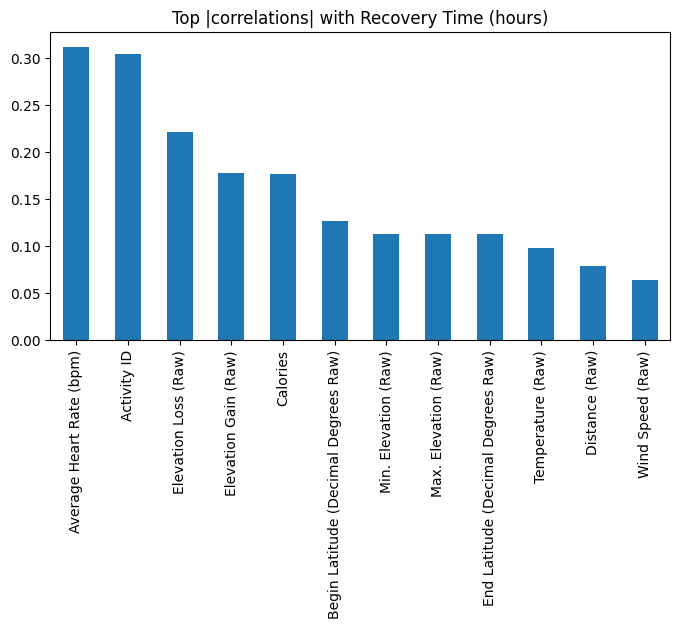

In [12]:
import numpy as np
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
corr = df_model[num_cols].corr()

# Pull top correlations with the target
target_corr = corr["recovery_time_hours"].drop(labels=["recovery_time_hours"]).sort_values(ascending=False)

print("Top positive correlations with recovery_time_hours:")
print(target_corr.head(10))
print("\nTop negative correlations with recovery_time_hours:")
print(target_corr.tail(10))

# Simple bar chart for top |correlations|
topk = target_corr.abs().sort_values(ascending=False).head(12)
plt.figure(figsize=(8,4))
topk.plot(kind="bar")
plt.title("Top |correlations| with Recovery Time (hours)")
plt.show()


In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, accuracy_score, confusion_matrix

df_model = df_model.sort_values("Begin Timestamp").reset_index(drop=True)
split_idx = int(len(df_model) * 0.8)

train_df = df_model.iloc[:split_idx].copy()
test_df  = df_model.iloc[split_idx:].copy()

X_train = train_df[feature_cols].copy()
X_test  = test_df[feature_cols].copy()

y_reg_train = train_df["recovery_time_hours"].values
y_reg_test  = test_df["recovery_time_hours"].values

y_cls_train = train_df["recovery_bucket"].values
y_cls_test  = test_df["recovery_bucket"].values

# -----------------------
# 4. Preprocess pipeline
# -----------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [23]:
# --- Refit regression models to restore best_reg_pipe ---

reg_models = {
    "Ridge": Ridge(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1, min_samples_leaf=2
    )
}

reg_pipes = {}
results = []
for name, model in reg_models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])
    pipe.fit(X_train, y_reg_train)
    reg_pipes[name] = pipe
    y_pred = pipe.predict(X_test)
    results.append((name,
                    r2_score(y_reg_test, y_pred),
                    mean_absolute_error(y_reg_test, y_pred)))

# Pick the best regression by lowest MAE
best_reg_name, _, _ = sorted(results, key=lambda x: x[2])[0]
best_reg_pipe = reg_pipes[best_reg_name]

print("Best regression model:", best_reg_name)

Best regression model: RandomForestRegressor


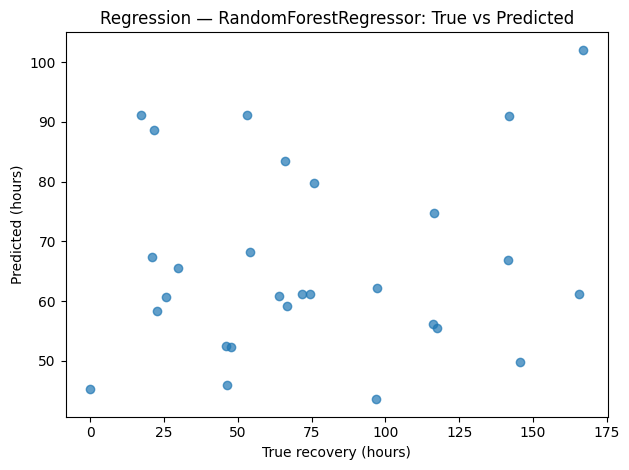

In [25]:
# --- Regression true vs predicted ---
reg_pred = best_reg_pipe.predict(X_test)

plt.figure()
plt.scatter(y_reg_test, reg_pred, alpha=0.7)
plt.xlabel("True recovery (hours)")
plt.ylabel("Predicted (hours)")
plt.title(f"Regression — {best_reg_name}: True vs Predicted")
plt.tight_layout()
plt.show()


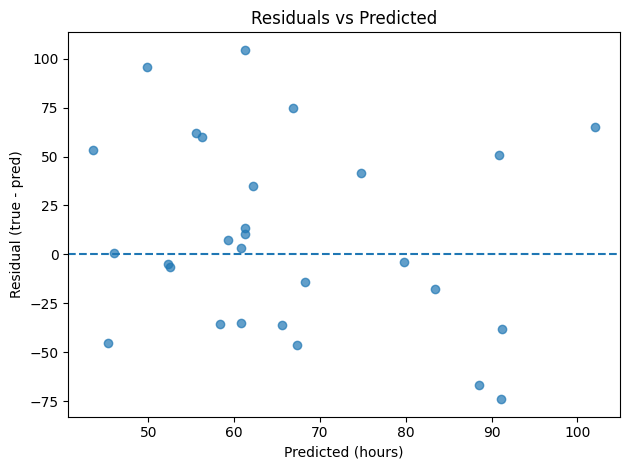

MAE: 39.3560010009749
RMSE: 48.58536483229137
Max over-pred: -74.03585618386246 Max under-pred: 104.52426697029831


In [27]:
import numpy as np
res = y_reg_test - reg_pred

# 1A. Residual scatter (should look like noise around 0)
plt.figure()
plt.scatter(reg_pred, res, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted (hours)"); plt.ylabel("Residual (true - pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout(); plt.show()

# 1B. Error summary
print("MAE:", np.mean(np.abs(res)))
print("RMSE:", np.sqrt(np.mean(res**2)))
print("Max over-pred:", res.min(), "Max under-pred:", res.max())


In [28]:
import numpy as np
from sklearn.pipeline import Pipeline

# Refit your best model with log1p target
y_train_log = np.log1p(y_reg_train)
pipe_log = Pipeline([("preprocess", preprocess), ("model", reg_pipes[best_reg_name].named_steps["model"])])
pipe_log.fit(X_train, y_train_log)

pred_log = pipe_log.predict(X_test)
pred_hours = np.expm1(pred_log)

# Compare
from sklearn.metrics import mean_absolute_error
print("MAE (original):", mean_absolute_error(y_reg_test, reg_pred))
print("MAE (log target):", mean_absolute_error(y_reg_test, pred_hours))


MAE (original): 39.3560010009749
MAE (log target): 39.88701895111452
